In [1]:
# !kaggle datasets download -d titericz/imagenet1k-val
# !unzip imagenet1k-val.zip
# !cp imagenet/imagenet_subtrain/mapping.json imagenet-val/mapping.json

In [2]:
from imagenet.dataset import ImagenetDataset
from torchvision import models

dataset = ImagenetDataset(root='imagenet-val', transform=models.ViT_B_16_Weights.IMAGENET1K_V1.transforms())

In [3]:
from utils import test_model
from quantize_linear import * 
from quantize_model import create_quantized_model
import pandas as pd

layer_types = [
    QuantizedLinear,
    QuantizedHadamardLinear,
    QuantizedPermutationLinear,
    QuantizedPermutationNoiseLinear
]
numbers_in_range_list = [16, 32, 64, 128, 256]
results = []
model_names = ['vit_b_16', 'vit_b_32', 'vit_l_16']
num_samples = 2048
batch_size = 16

total_iterations = len(model_names) * (1 + len(layer_types) * len(numbers_in_range_list))

with tqdm(total=total_iterations) as pbar:
    for model_name in model_names:
        if model_name == 'vit_b_16':
            model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).cuda()
        elif model_name == 'vit_b_32':
            model = models.vit_b_32(weights=models.ViT_B_32_Weights.IMAGENET1K_V1).cuda()
        elif model_name == 'vit_l_16':
            model = models.vit_l_16(weights=models.ViT_L_16_Weights.IMAGENET1K_V1).cuda()
        else:
            continue  # Skip any undefined model names

        # Baseline accuracy (without quantization)
        acc1, acc1_std, acc5, acc5_std, total = test_model(
            dataset,
            model,
            num_samples=num_samples,
            batch_size=batch_size
        )

        results.append({
            'model_name': model_name,
            'layer_type': 'Baseline',
            'min_range': None,
            'max_range': None,
            'numbers_in_range': None,
            'accuracy_top1_mean': acc1,
            'accuracy_top1_std': acc1_std,
            'accuracy_top5_mean': acc5,
            'accuracy_top5_std': acc5_std
        })
        pbar.update(1)

        for layer_type in layer_types:
            for numbers_in_range in numbers_in_range_list:
                min_range = - (numbers_in_range // 2)
                max_range = min_range + numbers_in_range - 1

                pbar.set_description(
                    f"Model: {model_name}, Layer: {layer_type.__name__}, Numbers in range: {numbers_in_range}"
                )

                quantized_model = create_quantized_model(
                    model,
                    layer_type=layer_type,
                    min_range=min_range,
                    max_range=max_range
                ).cuda()

                acc1, acc1_std, acc5, acc5_std, total = test_model(
                    dataset,
                    quantized_model,
                    num_samples=num_samples,
                    batch_size=batch_size
                )

                results.append({
                    'model_name': model_name,
                    'layer_type': layer_type.__name__,
                    'min_range': min_range,
                    'max_range': max_range,
                    'numbers_in_range': numbers_in_range,
                    'accuracy_top1_mean': acc1,
                    'accuracy_top1_std': acc1_std,
                    'accuracy_top5_mean': acc5,
                    'accuracy_top5_std': acc5_std
                })

                del quantized_model
                torch.cuda.empty_cache()
                pbar.update(1)

        del model
        torch.cuda.empty_cache()

results_df = pd.DataFrame(results)
display(results_df)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.83%
acc@5 on the sample batch: 95.46%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 2.68%
acc@5 on the sample batch: 8.00%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 75.41%
acc@5 on the sample batch: 92.39%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.54%
acc@5 on the sample batch: 94.98%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.63%
acc@5 on the sample batch: 95.22%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.68%
acc@5 on the sample batch: 95.37%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 61.80%
acc@5 on the sample batch: 80.83%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.54%
acc@5 on the sample batch: 94.63%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.63%
acc@5 on the sample batch: 95.22%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.73%
acc@5 on the sample batch: 95.27%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.54%
acc@5 on the sample batch: 95.51%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.46%
acc@5 on the sample batch: 94.63%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.78%
acc@5 on the sample batch: 95.37%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.98%
acc@5 on the sample batch: 95.32%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.68%
acc@5 on the sample batch: 95.41%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.73%
acc@5 on the sample batch: 95.41%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.76%
acc@5 on the sample batch: 94.54%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.10%
acc@5 on the sample batch: 95.12%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.54%
acc@5 on the sample batch: 95.41%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.68%
acc@5 on the sample batch: 95.32%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 80.73%
acc@5 on the sample batch: 95.46%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.39%
acc@5 on the sample batch: 92.10%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 1.46%
acc@5 on the sample batch: 5.02%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 71.85%
acc@5 on the sample batch: 90.00%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 71.07%
acc@5 on the sample batch: 87.41%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.00%
acc@5 on the sample batch: 91.85%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.39%
acc@5 on the sample batch: 92.15%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 33.61%
acc@5 on the sample batch: 52.59%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 74.00%
acc@5 on the sample batch: 90.98%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.39%
acc@5 on the sample batch: 91.90%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.15%
acc@5 on the sample batch: 92.10%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.44%
acc@5 on the sample batch: 92.20%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 73.66%
acc@5 on the sample batch: 91.17%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.24%
acc@5 on the sample batch: 92.05%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.63%
acc@5 on the sample batch: 91.90%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.39%
acc@5 on the sample batch: 92.10%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.24%
acc@5 on the sample batch: 91.90%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 73.71%
acc@5 on the sample batch: 90.15%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.20%
acc@5 on the sample batch: 91.95%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.59%
acc@5 on the sample batch: 91.85%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.34%
acc@5 on the sample batch: 92.00%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 76.39%
acc@5 on the sample batch: 92.10%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.07%
acc@5 on the sample batch: 93.80%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 75.17%
acc@5 on the sample batch: 90.49%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 78.59%
acc@5 on the sample batch: 93.61%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 78.68%
acc@5 on the sample batch: 93.85%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.02%
acc@5 on the sample batch: 93.90%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.12%
acc@5 on the sample batch: 93.95%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 78.93%
acc@5 on the sample batch: 93.90%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 78.98%
acc@5 on the sample batch: 93.76%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.37%
acc@5 on the sample batch: 93.80%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.27%
acc@5 on the sample batch: 94.00%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.07%
acc@5 on the sample batch: 93.85%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.12%
acc@5 on the sample batch: 93.80%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.41%
acc@5 on the sample batch: 93.80%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.02%
acc@5 on the sample batch: 93.76%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.22%
acc@5 on the sample batch: 93.85%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.07%
acc@5 on the sample batch: 93.80%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 78.98%
acc@5 on the sample batch: 94.20%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.17%
acc@5 on the sample batch: 93.90%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 78.98%
acc@5 on the sample batch: 93.71%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.12%
acc@5 on the sample batch: 93.85%


  0%|          | 0/128 [00:00<?, ?it/s]

acc@1 on the sample batch: 79.22%
acc@5 on the sample batch: 93.80%


,model_name,layer_type,min_range,max_range,numbers_in_range,accuracy_top1_mean,accuracy_top1_std,accuracy_top5_mean,accuracy_top5_std
0,vit_b_16,Baseline,NaN,NaN,NaN,0.808293,0.008692,0.954634,0.004595
1,vit_b_16,QuantizedLinear,-8.0,7.0,16.0,0.026829,0.003568,0.080000,0.005990
2,vit_b_16,QuantizedLinear,-16.0,15.0,32.0,0.754146,0.009508,0.923902,0.005855
3,vit_b_16,QuantizedLinear,-32.0,31.0,64.0,0.805366,0.008742,0.949756,0.004824
4,vit_b_16,QuantizedLinear,-64.0,63.0,128.0,0.806341,0.008726,0.952195,0.004711
...,...,...,...,...,...,...,...,...,...
58,vit_l_16,QuantizedPermutationNoiseLinear,-8.0,7.0,16.0,0.789756,0.008998,0.941951,0.005163
59,vit_l_16,QuantizedPermutationNoiseLinear,-16.0,15.0,32.0,0.791707,0.008967,0.939024,0.005284
60,vit_l_16,QuantizedPermutationNoiseLinear,-32.0,31.0,64.0,0.789756,0.008998,0.937073,0.005362
61,vit_l_16,QuantizedPermutationNoiseLinear,-64.0,63.0,128.0,0.791220,0.008975,0.938537,0.005303


In [19]:
results_df.model_name.unique()

array(['vit_b_16', 'vit_b_32', 'vit_l_16'], dtype=object)

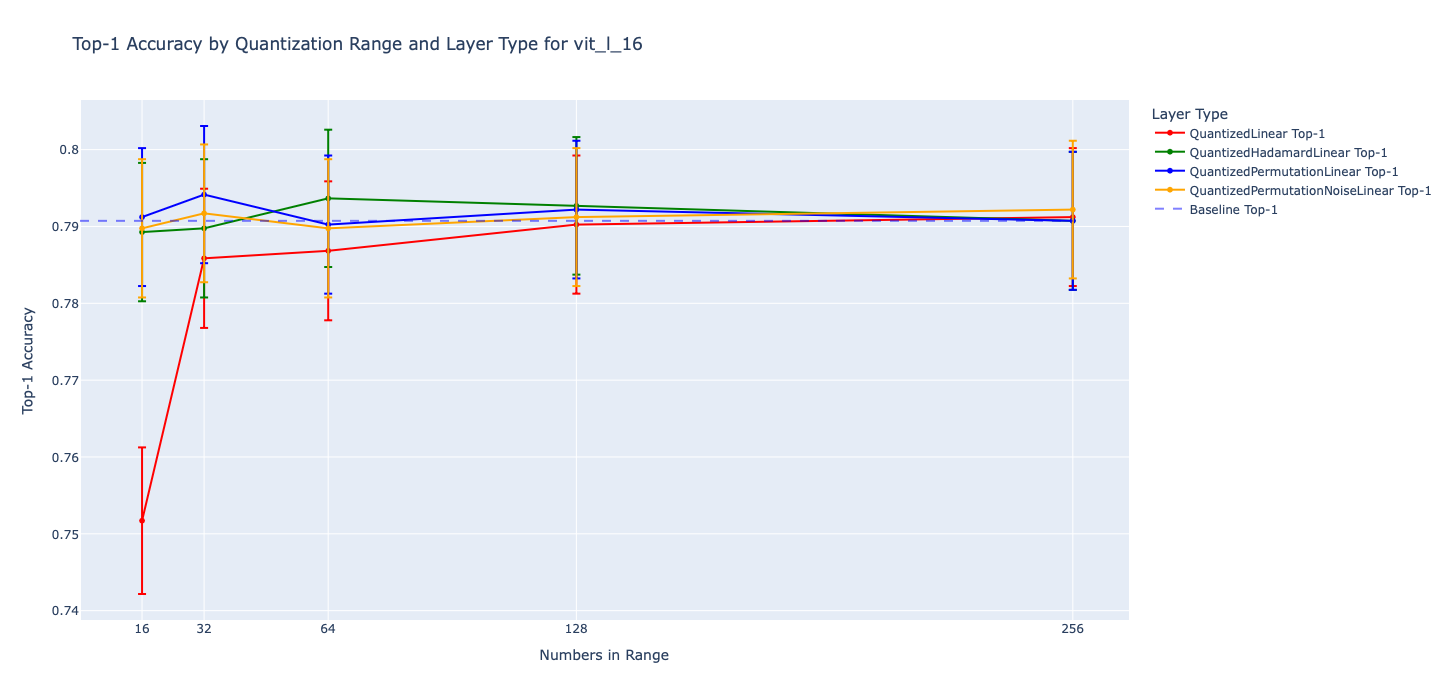

In [26]:
import plotly.express as px
import plotly.graph_objects as go

df = results_df[results_df.model_name == 'vit_l_16']
# Create figure
fig = go.Figure()

color_map = {
    'QuantizedLinear': 'red',
    'QuantizedHadamardLinear': 'green',
    'QuantizedPermutationLinear': 'blue',
    'QuantizedPermutationNoiseLinear': 'orange'
}

# Add scatter plots for each layer_type
for layer_type in df['layer_type'].unique():
    if layer_type == 'Baseline':
        continue
    layer_data = df[df['layer_type'] == layer_type]
    fig.add_trace(go.Scatter(
        x=layer_data['numbers_in_range'],
        y=layer_data['accuracy_top1_mean'],
        mode='lines+markers',
        name=f'{layer_type} Top-1',
        error_y=dict(
            type='data',
            array=layer_data['accuracy_top1_std'],
            visible=True
        ),
        line=dict(color=color_map[layer_type])
    ))

# Add baseline accuracy as a dotted line
baseline_data = df[df['layer_type'] == 'Baseline']
fig.add_trace(go.Scatter(
    x=[0, 256],
    y=[baseline_data['accuracy_top1_mean'].values[0]] * 2,
    mode='lines',
    line=dict(dash='dash', color='rgba(0, 0, 255, 0.5)'),
    name='Baseline Top-1'
))

# Update layout to make the graph more squarish
fig.update_layout(
    title='Top-1 Accuracy by Quantization Range and Layer Type for vit_l_16',
    xaxis=dict(
        title='Numbers in Range',
        tickmode='array',
        tickvals=[16, 32, 64, 128, 256],
        ticktext=['16', '32', '64', '128', '256']
    ),
    yaxis_title='Top-1 Accuracy',
    legend_title='Layer Type',
    width=1100,  # Adjust width to make plot more squarish
    height=700  # Adjust height to make plot more squarish
)

# Show figure
fig.show()

In [9]:
results_df.to_csv('results_vit_imagenet.csv')